In [2]:
import os
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Download all of label data as part B requires the analysis to be performed on all manufacturers

In [7]:
def extract_relevant_data(input_data, data, counter=0):
    """
    Transform and keep relevant columns only
    """
    for record in input_data:
        counter += 1
        transformed_record = dict()
        # Did a small analysis to verify that manufacturer name and brand names have length of 1
        # Query to verify above: set([len(i['openfda']['manufacturer_name']) for i in x.json()['results']])
        transformed_record['manufacturer_names'] = record['openfda'].get('manufacturer_name',[''])[0]
        transformed_record['brand_name'] = record['openfda'].get('brand_name',[''])[0]
        transformed_record['year'] = record.get('effective_time','')[:4]
        transformed_record['ingredient_count'] = len(record.get('spl_product_data_elements',[''])[0].split(','))
        transformed_record['route'] = record['openfda'].get('route',[''])[0]
        data.append(transformed_record)
    return

In [8]:
def download_data(mode):
    """
    This function downloads the data from either the API's which is termed as live mode
    or from disk where some files have been downloaded and unzipped.
    """
    if mode == 'live':
        flag = True
        data = []
        skip = False
        while flag:
            if skip:
                input_data = requests.get('https://api.fda.gov/drug/label.json?api_key=eYVVycw33g2qRw1ghFQBUHEIR3YuAhC4AamnwRiO&skip=100&limit=100')
            else:
                input_data = requests.get('https://api.fda.gov/drug/label.json?api_key=eYVVycw33g2qRw1ghFQBUHEIR3YuAhC4AamnwRiO&limit=100')
            skip = True    
            counter = 0
            extract_relevant_data(input_data.json()['results'], data, counter)
            if counter < 100:
                flag = False      
    elif mode == 'read_from_disk':
        data = []
        # Did a bit of work on bash of downloading and unzipping the files and creating the folder AstraZeneca with the required data
        path = os.getcwd() + '/AstraZeneca/'
        for file_name in os.listdir(path):
            input_data = json.load(open(path + file_name))
            extract_relevant_data(input_data['results'], data)
    return data

In [9]:
data = download_data('read_from_disk')

# PART A

In [11]:
# Retrieve data relevant to astrazeneca only
astrazeneca_data = [i for i in data if 'Astra' in i['manufacturer_names']]
df = pd.DataFrame(astrazeneca_data)
df = df[df['brand_name']!='']

## Visualize 

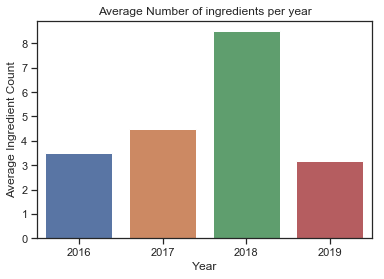

In [82]:
ax = sns.barplot(x='year',y='ingredient_count', data=df.groupby('year')['ingredient_count'].mean().round(2).reset_index())
ax.set(xlabel='Year', ylabel='Average Ingredient Count')
ax.set_title('Average Number of ingredients per year')
plt.show()

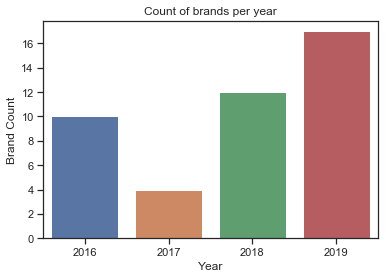

In [83]:
ax = sns.barplot(x='year',y='brand_name', data=df.groupby('year').agg({'brand_name':'size'}).reset_index())
ax.set(xlabel='Year', ylabel='Brand Count')
ax.set_title('Count of brands per year')
plt.show()

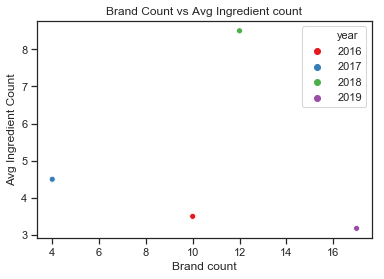

In [84]:
ax = sns.scatterplot(x='brand_name',y='ingredient_count',
                data=df.groupby('year').agg({'brand_name':'size','ingredient_count':'mean'}).reset_index(),
                hue='year',palette=sns.color_palette("Set1", len(df['year'].unique())))
ax.set(xlabel='Brand count', ylabel='Avg Ingredient Count')
ax.set_title('Brand Count vs Avg Ingredient count')
plt.show()

In [85]:
interim_df1 = df.groupby('year')['ingredient_count'].mean().round(2).reset_index()
interim_df2 = df.groupby('year')['brand_name'].apply(','.join).reset_index()
final_df_parta = pd.merge(interim_df1,interim_df2)
final_df_parta

,year,ingredient_count,brand_name
0,2016,3.50,"ZOLADEX,PULMICORT RESPULES,ATACAND HCT,ATACAND..."
1,2017,4.50,"CASODEX,CALQUENCE,FASENRA,Quetiapine Fumarate ..."
2,2018,8.50,"Lynparza,TAGRISSO,SEROQUEL XR,Esomeprazole mag..."
3,2019,3.18,"FARXIGA,ONGLYZA,FASLODEX,IRESSA,MERREM IV,SYMB..."


#### Number of drugs is not a signal for the average ingredient count.

# PART B

In [86]:
partb_df = pd.DataFrame(data)
partb_df = partb_df[partb_df['route']!='']
partb_final_df = partb_df.groupby(['year','route'])['ingredient_count'].mean().round(2).reset_index()
partb_final_df.head()

,year,route,ingredient_count
0,1960,ORAL,2.0
1,1971,ORAL,1.0
2,1973,ORAL,2.0
3,1974,ORAL,1.0
4,1977,ORAL,3.0


## Visualize

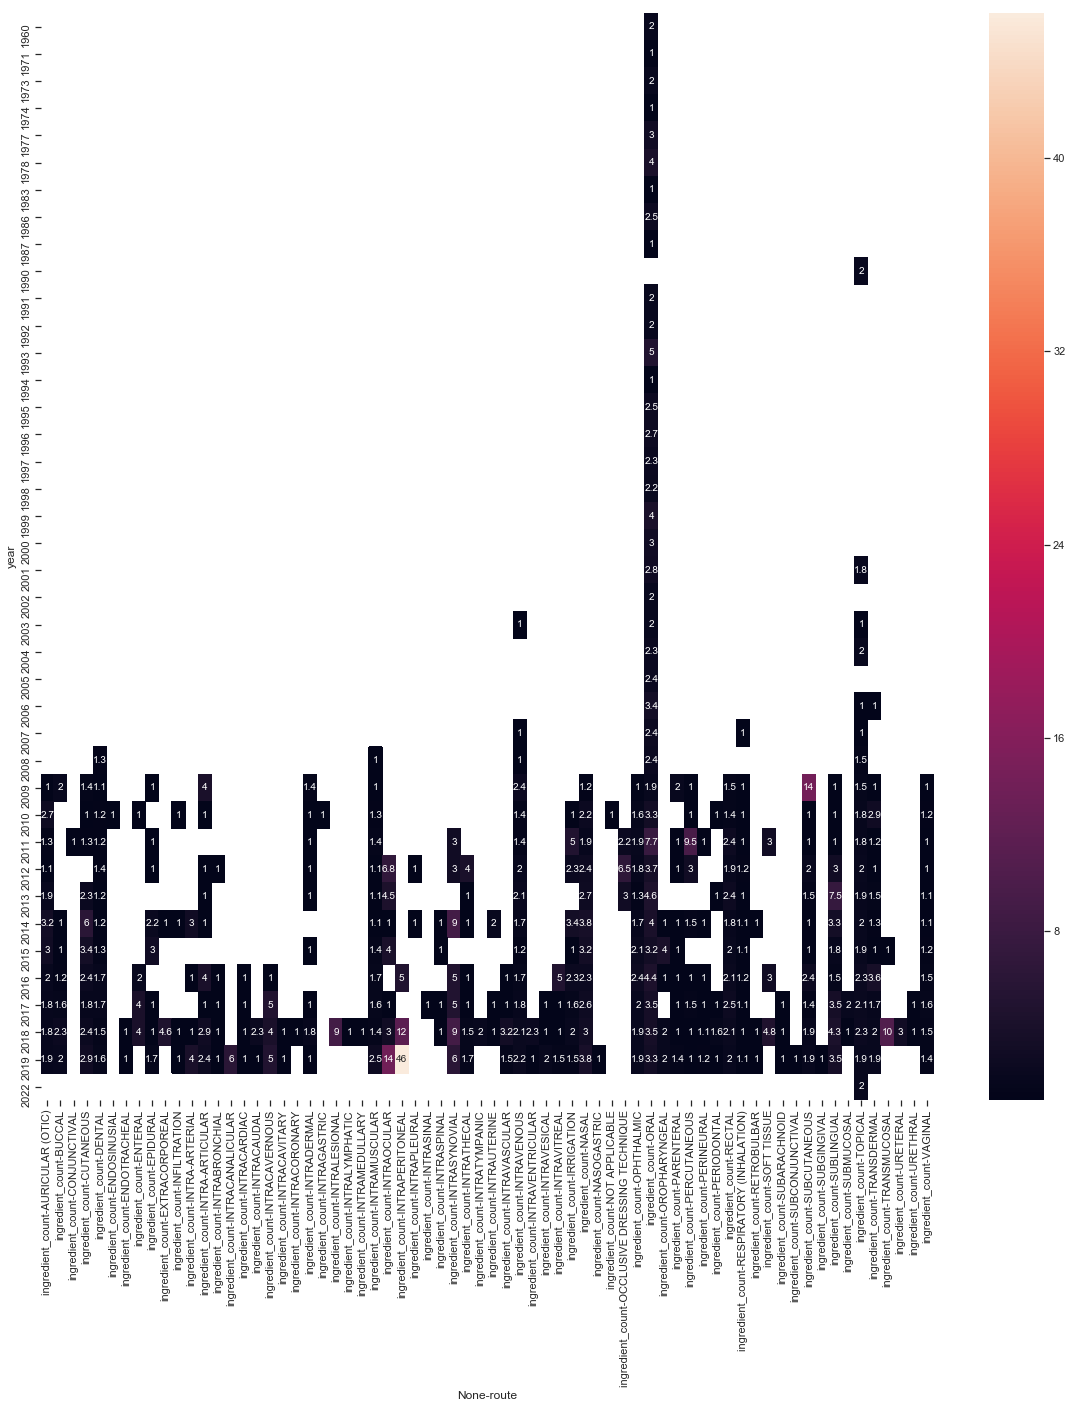

In [87]:
heatmap_df = partb_final_df.pivot(index='year',columns='route')
plt.figure(figsize=(20,20))
sns.heatmap(heatmap_df,annot=True)

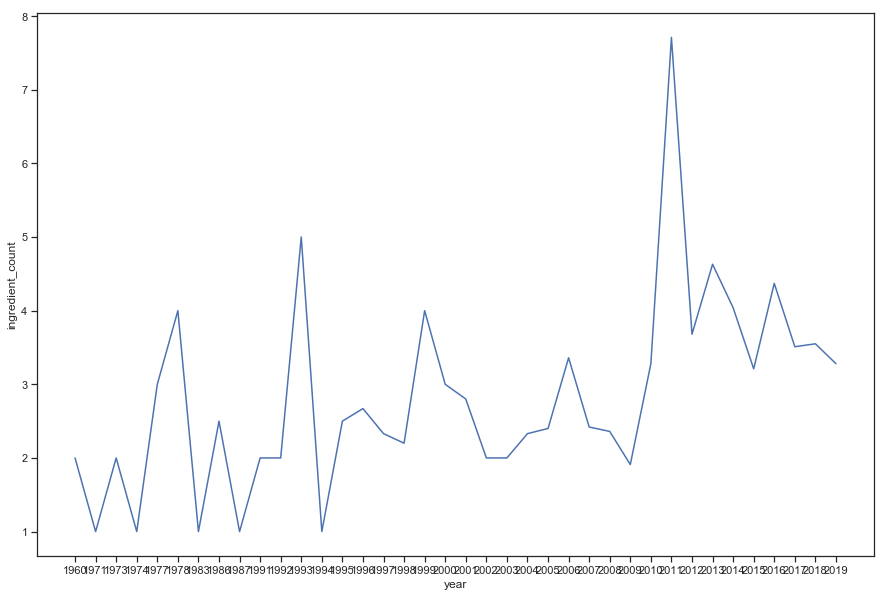

In [88]:
plt.figure(figsize=(15,10))
sns.lineplot(x='year',y='ingredient_count',data=partb_final_df[partb_final_df['route']=='ORAL'],hue='route',legend=False)

### The heatmap is just for visualizing all the data in one go. It helps us see that there is 1 brand which dates all the way back to 1960 while the remainder of the brands are relatively new. The lineplot helps us to visualize a pattern of ups and downs for the oral route as years progress indicating a cyclic behaviour.